In [1]:
from helpers.utilities import (
    DataFrame, Series, partial,
    T, F, pd
)
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
from jupyter_helpers.selective_import import notebooks_importer

In [4]:
from analyses.integration.Uniform_preprocessing import (
    # data matrices
    raw_protein_matrix, raw_rna_matrix,
    clinical_union as clinical,
    # misc
    RNA_OUTLIERS,
    patients_union, patients_union_series, patients_with_both,
    # full response vectors derived from clinical data for
    # the union of patients with CSF RNA or with protein data
    protein_conditions,
    # subsets of patients
    full_cm_and_tmdr,    # CM+TM+TMR patients with CSF RNA or protein data
    joint_cm_and_tmdr,   # CM+TM+TMR patients with both CSF RNA and protein data
    # preprocessing
    preprocess
)

Importing Jupyter notebook from /home/krassowski/meningitis/code/analyses/integration/Uniform_preprocessing.ipynb


### 0.3 OmicsPLS

NIPALS is referred to as "alternative" or "power" method; to use it one should set `p_thresh=1` (so that it is lower than number of features in X) or do an analogous thing with q_thresh. I will use NIPALS as it is much faster implementation (7min vs 1s)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from helpers.pls import format_grid_results
from helpers.o2pls import O2PLS, O2PLSStatistic
from helpers.o2pls import add_grid_metadata, summary_table_for
%R source('thirdparty/OmicsPLS_overrides.R');


Attaching package: ‘OmicsPLS’

The following object is masked from ‘package:stats’:

    loadings



Note: different rules for CV are used in SIMCA, as explained in "Multi- and Megavariate Data Analysis" Appendix II: Statistics, page 462 (Third revised edition). For predictive components threshold of Q2 > 0.01 is required (among other rules), for orthogonal components PCA rules apply.

A set of statistics will be computed during cross validation for every model:

In [6]:
cv_scoring = {
    name: statistic.calc
    for name, statistic in O2PLSStatistic.statistics.items()
}

In [7]:
%%R
import::here(
    grid_search_plot, grid_orthogonal_components_plot,
    .from='plots/omics_o2pls.R'
)

## 1. Logistic LASSO, using all data

(Logistic regression with L1 regularization)

First, a model using all the patients TMD, TMR and CM patients was trained in order to elucidate the potential biomarkers proteins with maximal power. 

Next, in order to exactly match the train-test split used in O2-PLS (due to limited number of samples) only the patients with data for both omics are used for training and patients with data for a single omic are used for validation.

In [8]:
from sklearn.linear_model import LogisticRegressionCV

In [9]:
%R import::here(plot_roc_auc, plot_coefficients, .from='plots/machine_learning.R')
from machine_learning.repeated_cv import (
    null_distributions_over_cv, repeated_cross_validation
)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: data.table
 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


In [10]:
cross_validate_single_ratio = partial(
    repeated_cross_validation,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=False,
    test_size_min=0.25,
    test_size_max=0.25,
    min_class_members=2
)

In [11]:
cross_validate = partial(
    repeated_cross_validation,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=True,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

In [12]:
%%R
import::here(
    coefficients_volcano_plot, plots_most_frequently_included,
    plot_most_significant, plot_highest_magnitutude,
    plot_roc_auc, mean_vs_coefficients,
    .from='plots/machine_learning.R'
)

### 1.1 Proteins:

In [13]:
protein_conditions.value_counts()

Tuberculosis       26
Healthy control    25
Cryptococcal       24
Viral               7
Name: Meningitis, dtype: int64

In [14]:
min(protein_conditions.value_counts())

7

In [15]:
joint_cm_and_tmdr.str.split('.').str[1].value_counts()

CM     14
TMD     7
TMR     4
dtype: int64

In [16]:
from machine_learning.multi_block_pipeline import predict_proba, TwoBlockPipeline
from machine_learning.preprocessing import ConditionsVectorizer, OutliersFilter


def two_blocks_with_supervision(data_block: DataFrame, conditions_vector: Series):
    conditions = list(conditions_vector)
    conditions = Series(conditions, index=conditions)
    return [data_block, conditions.loc[data_block.index]]


def subset(omic, subset, outliers=None):
    df = omic[omic.columns.intersection(subset)].T
    if outliers is not None:
        of = OutliersFilter(outlier_patients=outliers, verbose=True)
        df = of.fit_transform(df)
    return df

Just for diagnostics, we transform the protein matrix here:

In [17]:
protein_full = preprocess('protein', 7, None).fit_transform(raw_protein_matrix.T)

[1] "Retaining: 99.92%"


In [18]:
def create_lasso_pipeline(omic, smallest_group_n, outliers, subset=None, verbose=False, **kwargs):

    return TwoBlockPipeline(
        x=preprocess(omic, smallest_group_n, outliers, verbose=verbose, **kwargs),
        y=make_pipeline(
            OutliersFilter(outlier_patients=outliers, verbose=verbose),
            ConditionsVectorizer(mapping=clinical.Meningitis, case_class='Tuberculosis')
        ),
        combine=LogisticRegressionCV(
            penalty='l1', solver='liblinear',
            class_weight='balanced',
            max_iter=150
        ),
        predict=predict_proba
    )

In [19]:
lasso_pipeline_protein = create_lasso_pipeline(
    'protein',
    smallest_group_n=7,
    subset=full_cm_and_tmdr,
    outliers=None,
    verbose=False
)

[1] "Retaining: 99.92%"


In [20]:
protein_lasso = cross_validate(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    n=100,
    stratify=T,
    early_normalization=True
)

In [21]:
protein_lasso.cross_validation_results.metrics.accuracy_score(round=True).mean()

0.920584027084027

In [22]:
df = DataFrame(dict(
    cv_split_auc=protein_lasso.cross_validation_results.cv_auc,
    coefficients_count=protein_lasso.cross_validation.coefficients.x.non_zero_coeffs_count_by_cv
))

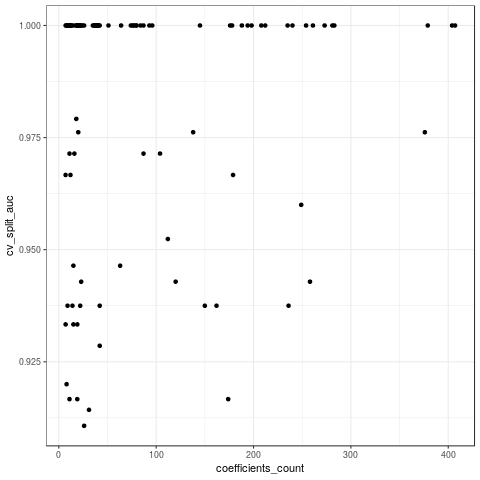

In [23]:
%%R -i df
(
    ggplot(df, aes(x=coefficients_count, y=cv_split_auc))
    + geom_point()
    + nice_theme
)

Many models have less than 50 coefficients; such models can achieve high scores anyway. Of course this is nested CV.

#### Coefficients co-selection network

In [24]:
network = protein_lasso.cross_validation.contributions.x.co_selection_network(
    contribution_threshold=0.01,
    selection_threshold=0.5
)

In [25]:
def format_selection_network(contra_network, contributions, key='log2_frequency_ratio'):
    cn = contra_network
    cn_labels = Series(list(set(cn.a) | set(cn.b))).reset_index().set_index(0)['index']
    cn['source'] = cn.a.map(cn_labels) + 1
    cn['destination'] = cn.b.map(cn_labels) + 1
    cn_contributions = contributions.data.loc[cn_labels.index]
    return cn, cn_contributions

In [26]:
cn, cn_contributions = format_selection_network(network, protein_lasso.cross_validation.contributions.x)

In [27]:
sanity_check = protein_full[list(set(cn.a) | set(cn.b))].assign(
    condition=lambda x: clinical.Meningitis.loc[x.index]
).groupby('condition').mean().T
sanity_check = DataFrame(dict(
    greater_mean_abundance=sanity_check.Tuberculosis > sanity_check.Cryptococcal,
    greater_mean_coeff=cn_contributions['mean'] > 0
))
assert all(sanity_check.greater_mean_abundance == sanity_check.greater_mean_coeff)

In [28]:
cn = cn[[*['source', 'destination'], *cn.columns.difference(['source', 'destination'])]]

Frequently co-selected pairs of proteins which contribute (on average) more than 5% of weight to the model:

In [29]:
cn.sort_values('weight')

,source,destination,a,b,count,frequency,log2_frequency_ratio,relative_weight,sign_agreement,weight
199,15,20,CXCL9,"FTL, FTH1",31,0.31,0.197707,3.307146,22,0.028390
247,8,6,INHBB,IL13RA1,23,0.23,-0.231326,-106.214137,0,0.030308
212,21,22,"ITGA1, ITGB1",CCL2,29,0.29,0.022057,1355.787486,0,0.030338
232,4,6,TNFSF15,IL13RA1,23,0.23,-0.309328,-12.335866,0,0.030586
250,15,6,CXCL9,IL13RA1,23,0.23,-0.148863,3.894911,14,0.030866
...,...,...,...,...,...,...,...,...,...,...
14,10,7,SLPI,CDH1,73,0.73,-0.243969,2.466471,68,0.174104
103,14,10,MMP10,SLPI,83,0.83,-0.165670,-10.114921,0,0.175027
273,14,21,MMP10,"ITGA1, ITGB1",19,0.19,-1.395351,-3.962398,0,0.176710
193,14,2,MMP10,TNFSF8,65,0.65,-0.357877,-2.501591,64,0.193791


TODO: clustering of coefficients with pvclust.

Loading required package: magrittr

Attaching package: ‘imager’

The following object is masked from ‘package:magrittr’:

    add

The following object is masked from ‘package:pROC’:

    ci

The following objects are masked from ‘package:stats’:

    convolve, spectrum

The following object is masked from ‘package:graphics’:

    frame

The following object is masked from ‘package:base’:

    save.image

network: Classes for Relational Data
Version 1.15 created on 2019-04-01.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.

Loading required package: sna
Loading required package: statnet.common

Attaching pack

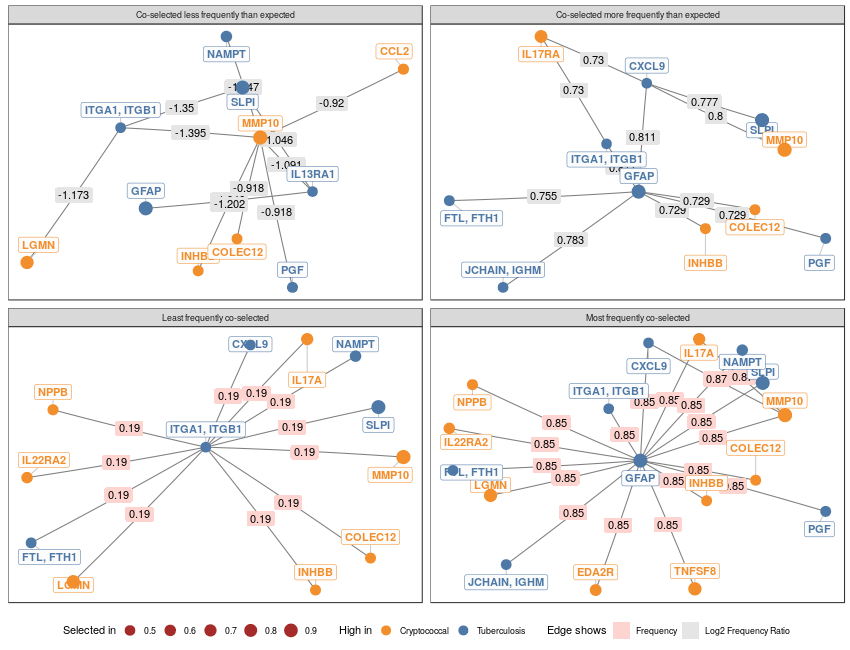

In [30]:
%%R -i cn -i cn_contributions -w 850 -h 650
import::here(plot_contributions_network, .from='plots/machine_learning.R')
import::here(optimize_space_usage, .from='plots/utils.R')
    
whites = optimize_space_usage(
    function(){
        plot_contributions_network(cn, cn_contributions, q=0.035)# + expand_limits(x = c(0.7, 0.8))
    },
    5
)
set.seed(which.max(whites))
p = plot_contributions_network(cn, cn_contributions, q=0.035)# + expand_limits(x = c(0.7, 0.8))
suppressMessages(ggsave('temp.png', p, dpi=80, w=10, h=7, scale=1.2))
p

The numbers on the lines indicate the average increase in contribution when the other gene was not included. If the protein from which the arrow starts is excluded, what is the increase in the importance of the protein to which the arrow points, relative to the importance of the excluded gene?

Correlations do not explain <s>many</s> some of the co-selections:

> <small>Changed on 24 August: Previously correlations were evaluated on `_pa` object, which contained TMM-normalized protein levels for the same subset of patients; differently however, the prefiltering step, deemed important for correct TMM normalization, was not used - but is now included in the creation of `protein_cm_and_tmdr`, reflecting fully the pre-processing pipeline used for training and testing. This decreased the p-values which were low, but not very low before.</small>

In [31]:
from scipy.stats import spearmanr

In [32]:
protein_cm_and_tmdr = subset(protein_full.T, full_cm_and_tmdr)

In [33]:
spearmanr(protein_cm_and_tmdr['ITGA1, ITGB1'], protein_cm_and_tmdr['GFAP'])

SpearmanrResult(correlation=0.15165609584214232, pvalue=0.325749315261612)

In [34]:
spearmanr(protein_cm_and_tmdr['MMP10'], protein_cm_and_tmdr['CXCL9'])

SpearmanrResult(correlation=-0.37364341085271313, pvalue=0.01247766717203849)

In [35]:
spearmanr(protein_cm_and_tmdr['MMP10'], protein_cm_and_tmdr['IL17A'])

SpearmanrResult(correlation=0.5291050035236081, pvalue=0.000221932840048023)

However, corelations do appear significant when two proteins are not co-selected:

In [36]:
spearmanr(protein_cm_and_tmdr['ITGA1, ITGB1'], protein_cm_and_tmdr['CXCL9'])

SpearmanrResult(correlation=0.6173361522198731, pvalue=8.060539543542305e-06)

In [37]:
spearmanr(protein_cm_and_tmdr['ITGA1, ITGB1'], protein_cm_and_tmdr['IL17A'])

SpearmanrResult(correlation=-0.539675828047921, pvalue=0.00015649199534195654)

Moreover, this pair of proteins which is co-selected less frequently than expected has quite high correlation:

In [38]:
spearmanr(protein_cm_and_tmdr['TNFSF15'], protein_cm_and_tmdr['MMP10'])

SpearmanrResult(correlation=0.7237491190979563, pvalue=2.8372988914101395e-08)

All of which warrants caution when interpreting this analysis.

TODO: overlay the predictions with DE heatmap, i.e. are there patients consistently misclassified and any special characteristic about them? 

In [39]:
protein_lasso.training_dataset.class_imbalance

0.45454545454545453

The class imbalance is moderate, thus I do not balance the CV splits futher; however, I still use weights proportional to the group cardinality in the regression model.

In [40]:
protein_lasso.cross_validation_results.metrics.accuracy_score(round=True).mean()

0.920584027084027

#### Singificance

In [41]:
cv_null_tbm = partial(
    null_distributions_over_cv, response=clinical.Meningitis, case_class='Tuberculosis',
    multi_scale=True,
    stratify=T,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

In [42]:
protein_lasso_null_distributions = cv_null_tbm(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    block='x',
    n=100,
    permutations=100,
    early_normalization=True
)

In [43]:
protein_lasso.cross_validation.coefficients.x.add_permutation_significance(
    protein_lasso_null_distributions.cross_validation.coefficients,
    n=25, decrease_n_by=5
)
protein_lasso.cross_validation.contributions.x.add_permutation_significance(
    protein_lasso_null_distributions.cross_validation.contributions,
    n=25, decrease_n_by=5
)

/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/krassowski/meningitis/code/helpers/p_values.py:133: UserWarning: A good GPD fit could not be reached, using ECDF estimate instead
  warn(f'A good GPD fit could not be reached, using ECDF estimate instead')


In [44]:
protein_coeffs = protein_lasso.cross_validation.coefficients.x.data
protein_contribs = protein_lasso.cross_validation.contributions.x.data

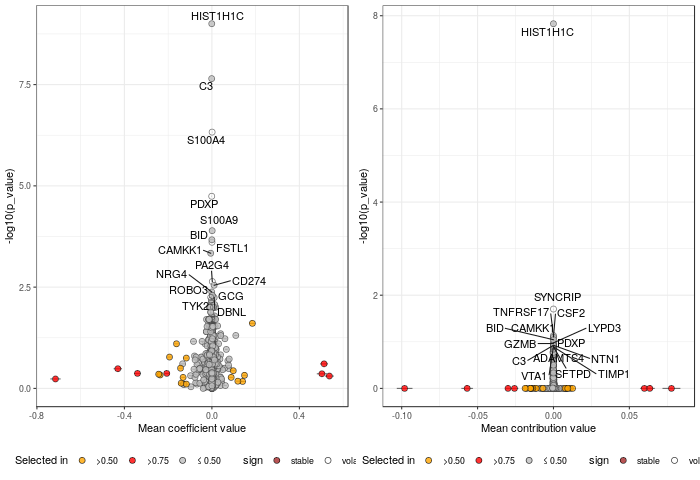

In [45]:
%%R -w 700 -i protein_coeffs -i protein_contribs
library(patchwork)
p1 = coefficients_volcano_plot(protein_coeffs, n=15) + ylab('Mean coefficient value')
p2 = coefficients_volcano_plot(protein_contribs, n=15) + ylab('Mean contribution value')
p1 + p2

**The permutation p-values obtained greatly differ from the initial results; I suspect that there might be an issue in the code...**

In [46]:
protein_lasso.cross_validation.contributions.x.add_hdi_significance(
    protein_lasso.training_dataset.x,
    protein_lasso.training_dataset.binary_response,
    family='binomial'
)

Loading required package: scalreg
Loading required package: lars
Loaded lars 1.2

Nodewise regressions will be computed as no argument Z was provided.
You can store Z to avoid the majority of the computation next time around.
Z only depends on the design matrix x.


In [47]:
protein_lasso.cross_validation.contributions.x.add_hdi_significance(
    protein_lasso.training_dataset.x,
    protein_lasso.training_dataset.binary_response,
    family='gaussian'
)

Nodewise regressions will be computed as no argument Z was provided.
You can store Z to avoid the majority of the computation next time around.
Z only depends on the design matrix x.


In [48]:
protein_lasso.cross_validation.contributions.x.add_weighted_auc(protein_lasso.cross_validation_results.cv_auc)

146 genes not selected in any model detected


In [49]:
protein_lasso.cross_validation.contributions.x.data

,mean,selected_in,positive_in,negative_in,volatile,...,binomial_p,binomial_FDR,gaussian_p,gaussian_FDR,weighted_auc
STUB1,-0.000031,0.03,0.01,0.02,0.666667,...,0.957675,0.999987,0.341076,0.630187,0.001035
CEBPB,0.000003,0.02,0.01,0.01,1.000000,...,0.991199,0.999987,0.309292,0.630187,0.000475
ENO2,0.000413,0.10,0.10,0.00,0.000000,...,0.987121,0.999987,0.078823,0.630187,0.004002
PIAS4,0.000002,0.01,0.01,0.00,0.000000,...,0.974548,0.999987,0.311114,0.630187,0.000217
IL10RA,0.000055,0.03,0.02,0.01,0.666667,...,0.954390,0.999987,0.340202,0.630187,0.002126
...,...,...,...,...,...,...,...,...,...,...,...
SERPINF1,-0.000037,0.01,0.00,0.01,0.000000,...,0.916576,0.999987,0.475890,0.657008,0.003681
CTSF,-0.000397,0.11,0.00,0.11,0.000000,...,0.977166,0.999987,0.823807,0.885618,0.003573
FTCD,0.000000,0.00,0.00,0.00,0.000000,...,0.940505,0.999987,0.326354,0.630187,0.000000
USP25,-0.000573,0.08,0.00,0.08,0.000000,...,0.989998,0.999987,0.543265,0.687261,0.006889


In [50]:
from math import log10
log10(0.05)

-1.3010299956639813

In [51]:
protein_contribs = protein_lasso.cross_validation.contributions.x.data

In [52]:
protein_coeffs = protein_lasso.cross_validation.coefficients.x.data

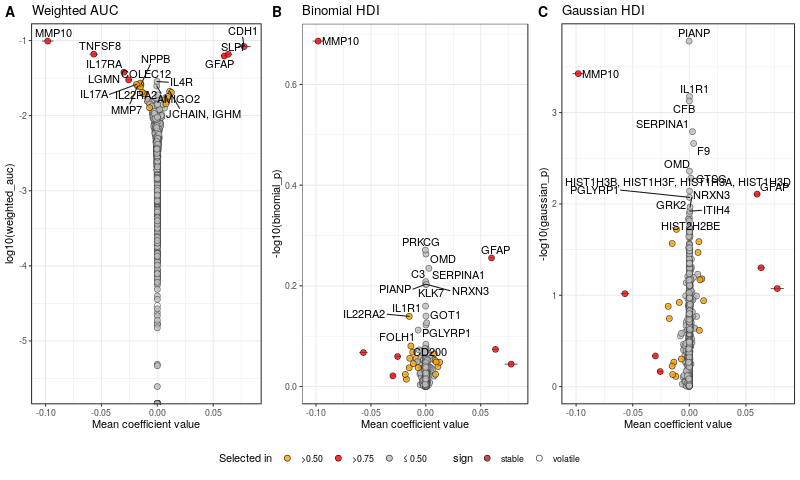

In [53]:
%%R -w 800 -i protein_contribs -i protein_coeffs
binomial = coefficients_volcano_plot(
    protein_contribs,
    n=15, p_value='binomial_p'
) + ylab('Mean coefficient value') + ggtitle('Binomial HDI')

gaussian = coefficients_volcano_plot(
    protein_contribs,
    n=15, p_value='gaussian_p'
) + ylab('Mean coefficient value') + ggtitle('Gaussian HDI')

weighted_auc = coefficients_volcano_plot(protein_contribs, n=15, p_value='weighted_auc', neg=F) + ylab('Mean coefficient value')  + ggtitle('Weighted AUC')
#permutation = coefficients_volcano_plot(protein_contribs, n=15) + ylab('Mean coefficient value') + ggtitle('Permutation')

legend = cowplot::get_legend(binomial)
no_legend = list(theme(legend.position='none'))
# TODO: add facet grid
cowplot::plot_grid(
    cowplot::plot_grid(
        weighted_auc + no_legend,
        binomial + no_legend,
        gaussian + no_legend,
        labels = c('A', 'B', 'C'),
        cols=3
    ),
    legend,
    rows=2,
    rel_heights = c(1, .1)
)

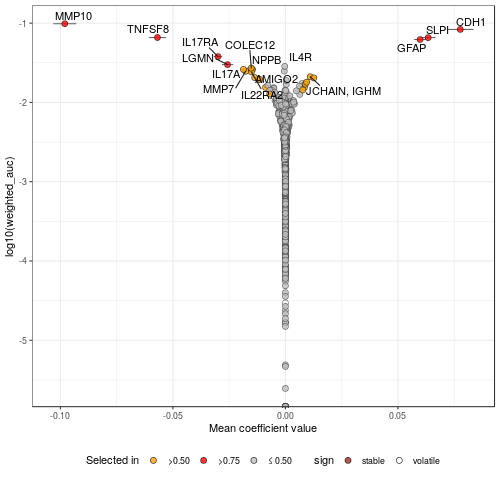

In [54]:
%%R -w 500 -i protein_contribs
coefficients_volcano_plot(
    protein_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean coefficient value')

Models including large contributions from MMP10, CDH1 and SLP have the highest AUC in cross validation.

In [55]:
protein_contribs['p_value'] = protein_contribs['binomial_p']

In [56]:
protein_contribs.sort_values('binomial_p')

,mean,selected_in,positive_in,negative_in,volatile,...,binomial_p,binomial_FDR,gaussian_p,gaussian_FDR,weighted_auc
MMP10,-0.098066,0.98,0.00,0.98,0.000000,...,0.205976,0.999987,0.000375,0.236954,0.098287
PRKCG,-0.000393,0.07,0.00,0.07,0.000000,...,0.535716,0.999987,0.022739,0.630187,0.005602
OMD,0.000112,0.06,0.06,0.00,0.000000,...,0.545544,0.999987,0.004379,0.630187,0.001865
GFAP,0.059877,0.95,0.95,0.00,0.000000,...,0.555352,0.999987,0.007817,0.630187,0.062139
SERPINA1,0.002806,0.29,0.29,0.00,0.000000,...,0.582384,0.999987,0.001620,0.410866,0.009627
...,...,...,...,...,...,...,...,...,...,...,...
ADAMTS4,-0.000003,0.01,0.00,0.01,0.000000,...,0.999833,0.999987,0.543722,0.687261,0.000331
PDE5A,-0.000198,0.10,0.00,0.10,0.000000,...,0.999867,0.999987,0.836818,0.893922,0.001930
FGF5,0.000094,0.06,0.06,0.00,0.000000,...,0.999891,0.999987,0.314264,0.630187,0.001567
ACVRL1,-0.000239,0.06,0.01,0.05,0.333333,...,0.999925,0.999987,0.439133,0.642980,0.004089


#### Single scale cross-validation

And the problem persists in single scale CV...

In [57]:
single_scale = dict(multi_scale=False, test_size_min=0.25, test_size_max=0.25)

In [58]:
protein_lasso_ss = cross_validate(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    n=100,
    stratify=T,
    early_normalization=True,
    **single_scale
)

In [59]:
cv_null_tbm_single_scale = partial(
    null_distributions_over_cv, response=clinical.Meningitis, case_class='Tuberculosis',
    stratify=T,
    min_class_members=2,
    **single_scale
)

In [60]:
protein_lasso_null_distributions_single_scale = cv_null_tbm_single_scale(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    block='x',
    n=100,
    permutations=100,
    verbose=F,
    early_normalization=True
)

In [61]:
protein_lasso_ss.cross_validation.coefficients.x.add_permutation_significance(
    protein_lasso_null_distributions_single_scale.cross_validation.coefficients,
    n=25, decrease_n_by=5
)
protein_lasso_ss.cross_validation.contributions.x.add_permutation_significance(
    protein_lasso_null_distributions_single_scale.cross_validation.contributions,
    n=25, decrease_n_by=5
)

/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/krassowski/meningitis/code/helpers/p_values.py:133: UserWarning: A good GPD fit could not be reached, using ECDF estimate instead
  warn(f'A good GPD fit could not be reached, using ECDF estimate instead')
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/skgof/ecdfgof.py:81: RuntimeWarning: divide by zero encountere

In [62]:
protein_coeffs_ss = protein_lasso_ss.cross_validation.coefficients.x.data
protein_contribs_ss = protein_lasso_ss.cross_validation.contributions.x.data

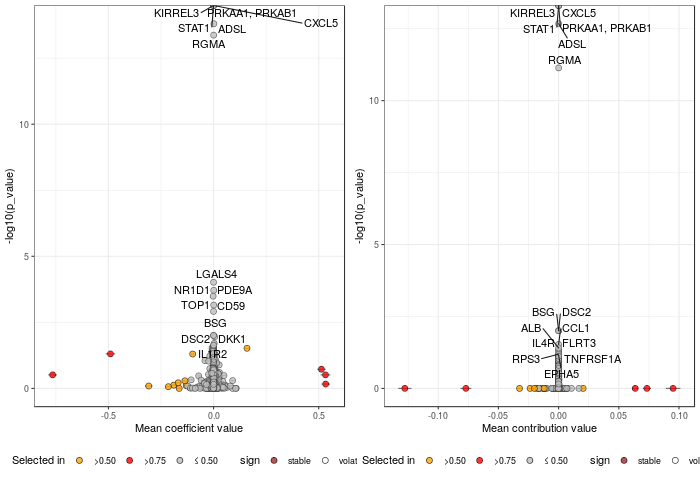

In [63]:
%%R -w 700 -i protein_coeffs_ss -i protein_contribs_ss
library(patchwork)
p1 = coefficients_volcano_plot(protein_coeffs_ss, n=15) + ylab('Mean coefficient value')
p2 = coefficients_volcano_plot(protein_contribs_ss, n=15) + ylab('Mean contribution value')
p1 + p2

#### Abundance

In [64]:
protein_contribs_subset = protein_lasso.cross_validation.contributions.x.select()

Adjusting non-zero ratio required to keep all significant coeffs
Selected 1122 coefficients different from zero in at least 0.01 repeats


In [65]:
groups = protein_full.index.map(clinical.Meningitis_with_tuberculosis_status)
protein_full.T.loc['PLA2G2A'].groupby(groups).mean()

Cryptococcal            -0.119399
Definite tuberculosis    0.824140
Healthy control         -0.259624
Possible tuberculosis    0.296479
Probable tuberculosis    0.265850
Viral                   -0.713927
Name: PLA2G2A, dtype: float64

In [66]:
protein_full.T.loc['MMP10'].groupby(groups).mean()

Cryptococcal             0.815169
Definite tuberculosis   -0.730617
Healthy control         -0.099009
Possible tuberculosis    0.203313
Probable tuberculosis   -0.709046
Viral                   -0.549625
Name: MMP10, dtype: float64

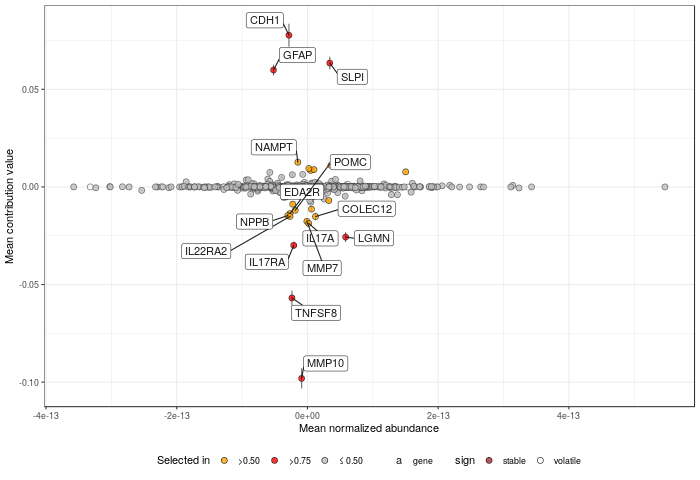

In [67]:
%%R -i protein_contribs -w 700
(
    mean_vs_coefficients(protein_contribs, n=15, fdr_threshold=NA)
    + ylab('Mean contribution value')
    + xlab('Mean normalized abundance')
)

#### Top coefficients

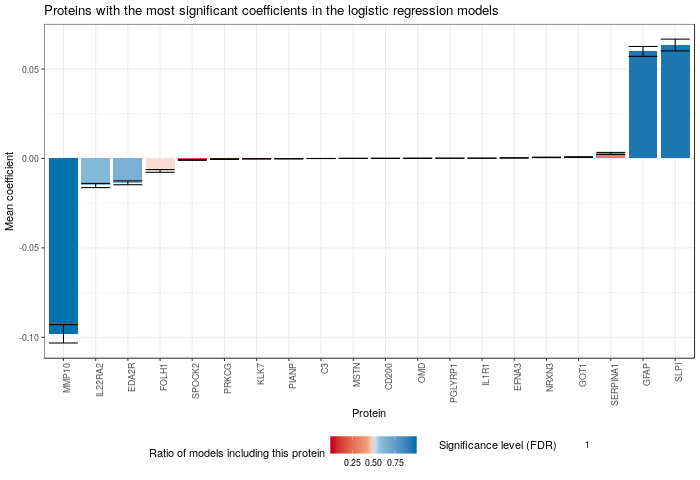

In [68]:
%%R -i protein_contribs -w 700
plot_most_significant(
    protein_contribs, n=20, label_margin=0.0,
    fill_name='Ratio of models including this protein',
    type='coefficient'
) + xlab('Protein') + ggtitle('Proteins with the most significant coefficients in the logistic regression models')

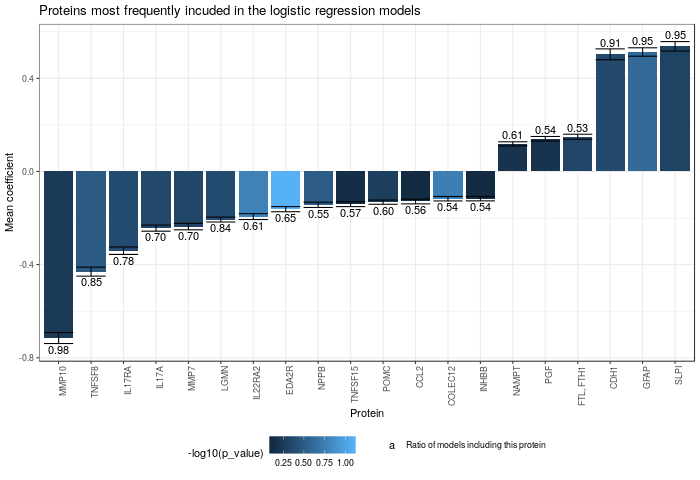

In [69]:
%%R -i protein_coeffs -w 700
plots_most_frequently_included(
    protein_coeffs, n=20, label_margin=0.01,
    label_name='Ratio of models including this protein',
    type='coefficient'
) + xlab('Protein') + ggtitle('Proteins most frequently incuded in the logistic regression models')

#### Top contributions

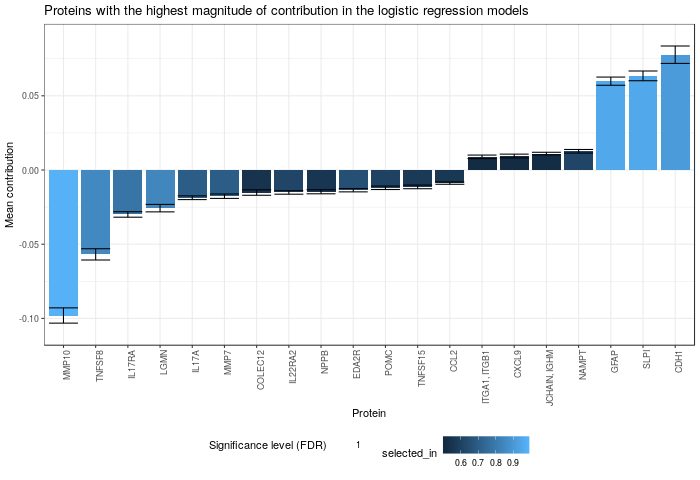

In [70]:
%%R -i protein_contribs -w 700
plot_highest_magnitutude(
    protein_contribs, n=20, label_margin=0.005,
    fill_name='Ratio of models including this protein',
) + xlab('Protein') + ggtitle('Proteins with the highest magnitude of contribution in the logistic regression models')

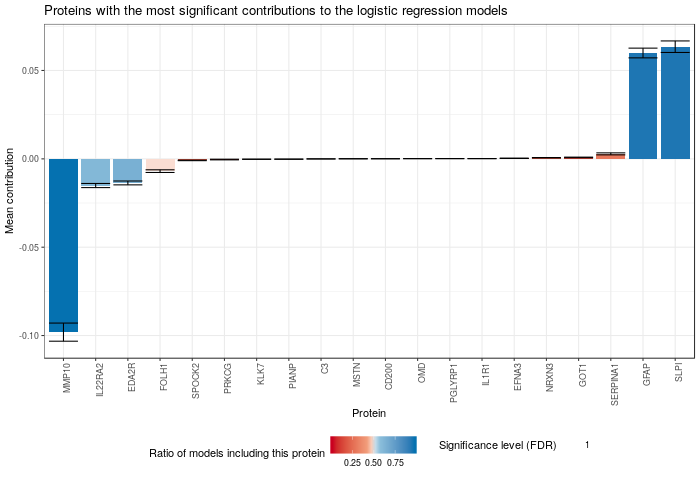

In [71]:
%%R -i protein_contribs -w 700
plot_most_significant(
    protein_contribs, n=20, label_margin=0.001,
    fill_name='Ratio of models including this protein'
) + xlab('Protein') + ggtitle('Proteins with the most significant contributions to the logistic regression models')

#### Cross-validation performance (is very high)

In [72]:
roc_auc = protein_lasso.cross_validation_results.roc_auc

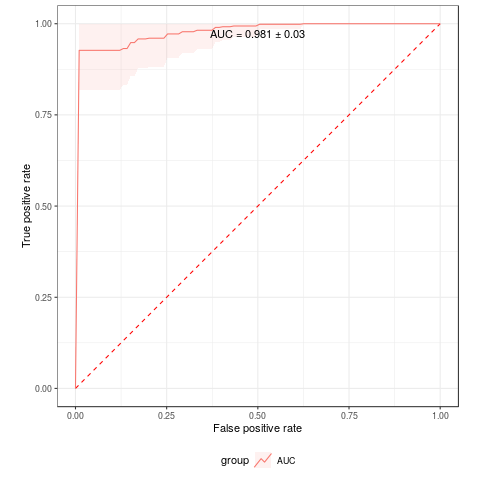

In [73]:
%%R -i roc_auc
plot_roc_auc(roc_auc, mean_auc=T)

### 1.2 Transcripts

Notes:
 - Pareto scaling/no scaling may improve RNA seq results, because it can "guide" the LASSO to select important variables

Again, only for diagnostic use:

In [74]:
rna_full = preprocess('rna', 7, RNA_OUTLIERS).fit_transform(raw_rna_matrix.T)

[1] "Retaining: 52.62%"


In [75]:
lasso_pipeline_rna = create_lasso_pipeline(
    'rna',
    smallest_group_n=7,
    subset=full_cm_and_tmdr,
    outliers=RNA_OUTLIERS,
    verbose=False
)

[1] "Retaining: 52.62%"


In [76]:
rna_lasso = cross_validate(
    lasso_pipeline_rna,
    two_blocks_with_supervision(
        subset(raw_rna_matrix, full_cm_and_tmdr, outliers=RNA_OUTLIERS),
        full_cm_and_tmdr
    ),
    n=100,
    verbose=F
)

OutliersFilter: filtering out 6 outliers


#### Abundance

In [77]:
rna_coeffs = rna_lasso.cross_validation.coefficients.x.data
rna_contribs = rna_lasso.cross_validation.contributions.x.data

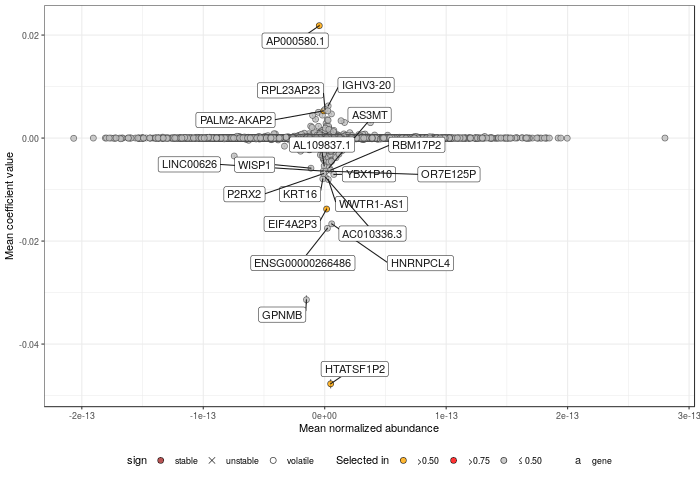

In [78]:
%%R -i rna_contribs -w 700
mean_vs_coefficients(rna_contribs, n=20, fdr_threshold=NA) + ylab('Mean coefficient value') + xlab('Mean normalized abundance')

#### Significance

HDI requires to remove the few non-expressed transcripts: 

In [79]:
rna_non_expressed_in_train = rna_lasso.training_dataset.x.sum() == 0
rna_lasso_train_zero_filtered = rna_lasso.training_dataset.x.loc[:, ~rna_non_expressed_in_train]

Filtering 15% of train data:

In [80]:
rna_non_expressed_in_train.sum() / len(rna_lasso_train_zero_filtered.columns)

0.1567938021454112

RNA dataset is still over 30 times bigger:

In [81]:
def mul(a):
    return a[0] * a[1]


rna_size = mul(rna_lasso_train_zero_filtered.shape)
protein_size = mul(protein_lasso.training_dataset.x.shape)

rna_size / protein_size

31.505257134682783

However the computation would not end in 20 hours (on 6 cores, using stripped version), and as no indication of remianing running time is provied it was skipped:

In [82]:
# rna_lasso.cross_validation.contributions.x.add_hdi_significance(
#    rna_lasso_train_zero_filtered,
#    rna_lasso.training_dataset.binary_response,
#    family='binomial',
#    cores=6,
#    suppress_group_testing=True,
#    verbose=True
# )

In [83]:
# %%R -i rna_contribs -w 700
# plots_most_frequently_included(
#     rna_contribs, n=20, label_margin=0.01,
#     label_name='Ratio of models including this transcript',
# ) + xlab('Transcript') + ggtitle('Transcripts most frequently incuded in the logistic regression models')

#### Features driving models with high AUC

In [84]:
rna_lasso.cross_validation.contributions.x.add_weighted_auc(rna_lasso.cross_validation_results.cv_auc)

10 null models detected
13498 genes not selected in any model detected


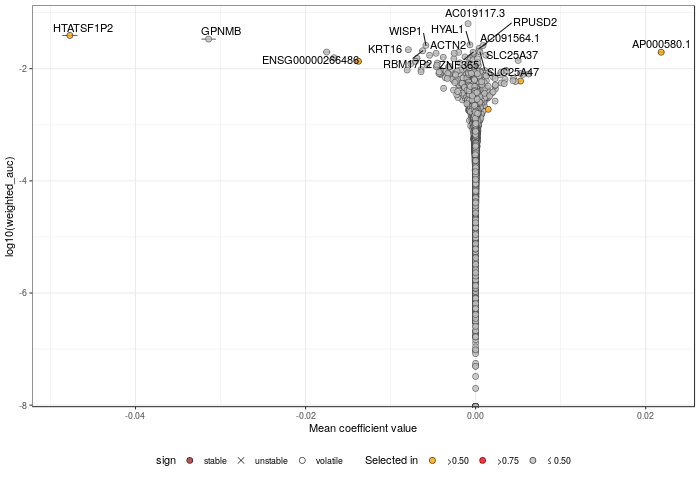

In [85]:
%%R -w 700 -i rna_contribs
coefficients_volcano_plot(
    rna_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean coefficient value')

- AP000580.1 - ribosomal protein S20 (RPS20) pseudogene, RSF1 neighborhood
- ENSG00000266486 - FAM106CP

#### Cross-validation performance (is low)

In [86]:
roc_auc = rna_lasso.cross_validation_results.roc_auc

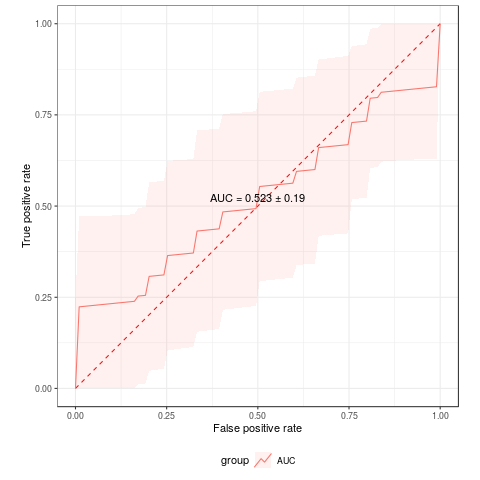

In [87]:
%%R -i roc_auc
plot_roc_auc(roc_auc, mean_auc=T)

#### Is this because of lack of the convergence ("too many variables"?)

In [88]:
shared_subset = protein_full.columns & rna_full.columns
rna_subset_lasso = cross_validate(
    lasso_pipeline_rna,
    two_blocks_with_supervision(
        subset(raw_rna_matrix.loc[shared_subset], full_cm_and_tmdr, outliers=RNA_OUTLIERS),
        full_cm_and_tmdr
    ),
    n=100,
    verbose=F
)

OutliersFilter: filtering out 6 outliers


In [89]:
roc_auc = rna_subset_lasso.cross_validation_results.roc_auc

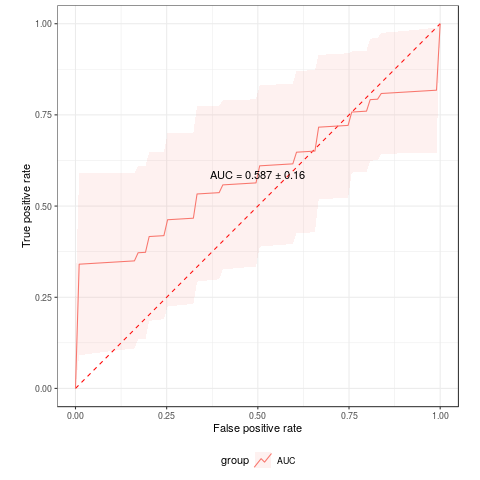

In [90]:
%%R -i roc_auc
plot_roc_auc(roc_auc, mean_auc=T)

## 2. Logistic LASSO with joint data only

In order not to contaminate our predictions with knowledge of the full dataset we strictly remove the data from outside of the subset:

In [91]:
patients_with_single_omic = Series(
    list(patients_union.difference(patients_with_both))
)

In [92]:
cm_and_tmdr_validation = patients_with_single_omic[
    patients_with_single_omic.str.contains('TMR|TMD|CM')
]

In [93]:
tms_validation = pd.concat([
    patients_union_series[patients_union_series.str.contains('TMS')],
    patients_with_single_omic[patients_with_single_omic.str.contains('CM')]
])

In [94]:
from machine_learning.data_classes import MultiBlockDataSet

tms_protein_dataset = MultiBlockDataSet(
    [*two_blocks_with_supervision(subset(raw_protein_matrix, tms_validation), tms_validation)],
    case_class='Tuberculosis',
    response=clinical.Meningitis
)
tms_rna_dataset = MultiBlockDataSet(
    [*two_blocks_with_supervision(subset(raw_rna_matrix, tms_validation, outliers=RNA_OUTLIERS), tms_validation)],
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 2 outliers


### 2.1 Proteins

In [95]:
lasso_pipeline_joint_protein = create_lasso_pipeline(
    'protein',
    smallest_group_n=7,
    subset=joint_cm_and_tmdr,
    outliers=None,
    verbose=False
)

[1] "Retaining: 99.92%"


Ideas:
- for O2-PLS - just pass the joint matrix to repeated cross validation and see what happens. This requires a simplified pipeline.
- for joint logistic: let's evaluate all the the random replicates on the patients with single omic! (training with everything, changing seed only OR also withholding some samples)

In [96]:
joint_protein_lasso = cross_validate(
    lasso_pipeline_joint_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, joint_cm_and_tmdr),
        joint_cm_and_tmdr
    ),
    test_data=two_blocks_with_supervision(
        subset(raw_protein_matrix, cm_and_tmdr_validation),
        cm_and_tmdr_validation
    ),
    n=100,
    verbose=F,
    stratify=T,
    early_normalization=False
)

In [97]:
tms_protein_result = joint_protein_lasso.validate(tms_protein_dataset)
tms_protein_result_sub = joint_protein_lasso.cross_validation.validate(tms_protein_dataset)

In [98]:
roc_auc = pd.concat([
    joint_protein_lasso.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    joint_protein_lasso.sub_sampling_test_results.roc_auc.assign(group='CV test: TMD+TMR vs CM', models='Cross-Validation', set='Test: TMD+TMR vs CM'),
    tms_protein_result_sub.roc_auc.assign(group='CV test: TMS vs CM', models='Cross-Validation', set='Test: TMS vs CM'),
    tms_protein_result.roc_auc.assign(group='Full test: TMS vs CM', models='Full model', set='Test: TMS vs CM'),
    joint_protein_lasso.test_result.roc_auc.assign(group='Full test: TMD+TMR vs CM', models='Full model', set='Test: TMD+TMR vs CM')
])

 vs 0.7746666666666667



Attaching package: ‘grid’

The following object is masked from ‘package:imager’:

    depth



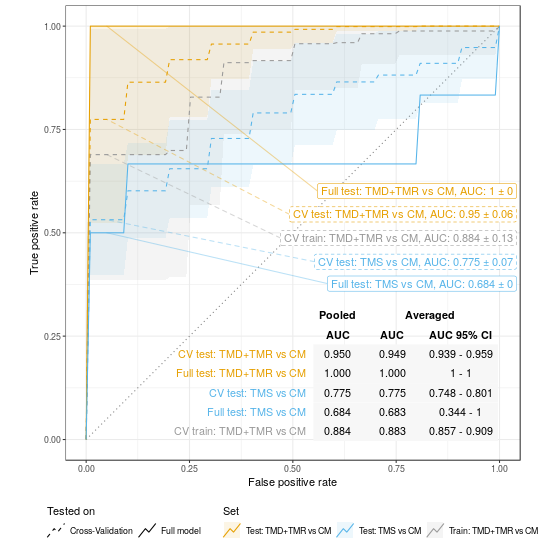

In [99]:
%%R -i roc_auc -w 550 -h 550
import::here(plot_roc_auc, add_linetype_to_ggrepel, .from='plots/machine_learning.R')
        
colors = c('Test: TMD+TMR vs CM'='#E69F00', 'Test: TMS vs CM'='#56B4E9', 'Train: TMD+TMR vs CM'='#999999')
p = (
    plot_roc_auc(
        roc_auc, annotate_lines=T, table=T,
        color='set', linetype='models',
        random_color='grey50', random_linetype=3,
        table_row_colors=colors, annotation_at=0.05,
        annotation_x=0.05, nudge_x=1,
        nudge_y=-1,
        direction='y',
        ylim=c(0.35, 0.65),
        table_xmin=0.45, table_xmax=0.75
    )
    + scale_color_manual(
        name='Set',
        values=colors
    )
    + scale_fill_manual(
        name='Set',
        values=colors
    )
    + scale_linetype_manual(
        name='Tested on',
        values=c('Cross-Validation'='dashed', 'Full model'='solid')
    )
    + guides(
        linetype=guide_legend(title.position='top'),
        fill=guide_legend(title.position='top'),
        color=guide_legend(title.position='top')
    )
    # + ggtitle()
)

line_types = c(2,1,2,1,2,2)
g = add_linetype_to_ggrepel(ggplotGrob(p), line_types, 'segment')
g = add_linetype_to_ggrepel(g, line_types, 'box')
p = grid.draw(g)

The ribbon highlights the distance of one standard deviation from the pooled AUC and is only drawn for the results based on CV models. The numbers given on the ROC curve labels are: pooled AUC +/- standard deviation.

Both tests sets were evaluated on all CV models to provide the error estimate.

TMD+TMR and CM use data of patients with single omic only.
TMS was composed of patients with single or both omics.

The use of the full model is unbiased, while the use of surrogate models is more informative (but pessimistic)

#### Features driving models with high AUC

In [100]:
joint_protein_lasso.cross_validation.contributions.x.add_weighted_auc(
    joint_protein_lasso.sub_sampling_test_results.cv_auc
)
joint_protein_contribs = joint_protein_lasso.cross_validation.contributions.x.data

234 genes not selected in any model detected


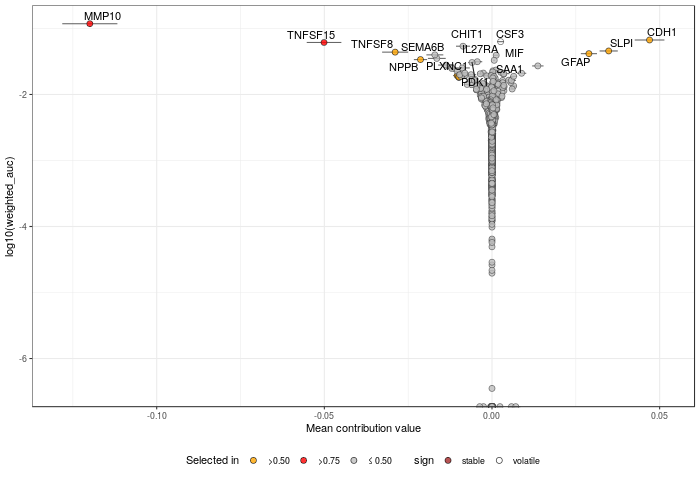

In [101]:
%%R -w 700 -i joint_protein_contribs
coefficients_volcano_plot(
    joint_protein_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean contribution value')

### 2.2 Transcripts

In [102]:
lasso_pipeline_joint_rna = create_lasso_pipeline(
    'rna',
    smallest_group_n=7,
    subset=joint_cm_and_tmdr,
    outliers=RNA_OUTLIERS,
    verbose=False
)

[1] "Retaining: 52.62%"


In [103]:
joint_rna_lasso = cross_validate(
    lasso_pipeline_joint_rna, 
    two_blocks_with_supervision(
        subset(raw_rna_matrix, joint_cm_and_tmdr, outliers=RNA_OUTLIERS),
        joint_cm_and_tmdr
    ),
    test_data=two_blocks_with_supervision(
        subset(raw_rna_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS),
        cm_and_tmdr_validation
    ),
    n=100,
    verbose=F,
    stratify=T,
    early_normalization=True
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 6 outliers


In [104]:
tms_rna_result = joint_rna_lasso.validate(tms_rna_dataset)
tms_rna_result_sub = joint_rna_lasso.cross_validation.validate(tms_rna_dataset)

In [105]:
roc_auc_joint_rna = pd.concat([
    joint_rna_lasso.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    joint_rna_lasso.sub_sampling_test_results.roc_auc.assign(group='CV test: TMD+TMR vs CM', models='Cross-Validation', set='Test: TMD+TMR vs CM'),
    tms_rna_result_sub.roc_auc.assign(group='CV test: TMS vs CM', models='Cross-Validation', set='Test: TMS vs CM'),
    tms_rna_result.roc_auc.assign(group='Full test: TMS vs CM', models='Full model', set='Test: TMS vs CM'),
    joint_rna_lasso.test_result.roc_auc.assign(group='Full test: TMD+TMR vs CM', models='Full model', set='Test: TMD+TMR vs CM')
])

 vs 0.9166666666666667


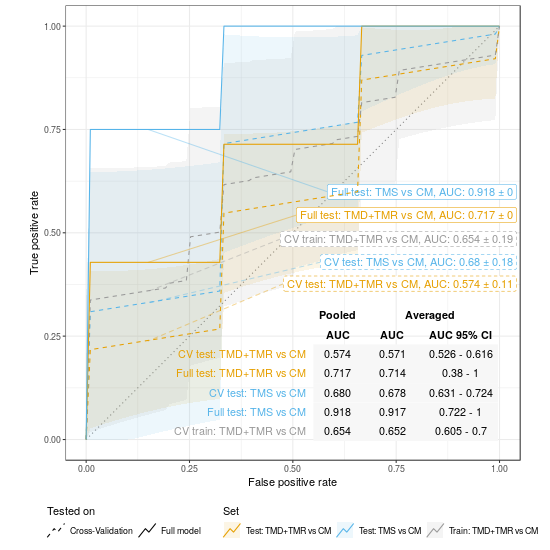

In [106]:
%%R -i roc_auc_joint_rna -w 550 -h 550
import::here(plot_roc_auc, add_linetype_to_ggrepel, .from='plots/machine_learning.R')
        
colors = c('Test: TMD+TMR vs CM'='#E69F00', 'Test: TMS vs CM'='#56B4E9', 'Train: TMD+TMR vs CM'='#999999')
p = (
    plot_roc_auc(
        roc_auc_joint_rna, annotate_lines=T, table=T,
        color='set', linetype='models',
        random_color='grey50', random_linetype=3,
        table_row_colors=colors, annotation_at=0.15,
        annotation_x=0.15, nudge_x=1,
        nudge_y=-1,
        direction='y',
        ylim=c(0.35, 0.65),
        table_xmin=0.45, table_xmax=0.75
    )
    + scale_color_manual(
        name='Set',
        values=colors
    )
    + scale_fill_manual(
        name='Set',
        values=colors
    )
    + scale_linetype_manual(
        name='Tested on',
        values=c('Cross-Validation'='dashed', 'Full model'='solid')
    )
    + guides(
        linetype=guide_legend(title.position='top'),
        fill=guide_legend(title.position='top'),
        color=guide_legend(title.position='top')
    )
    # + ggtitle()
)

line_types = c(2,1,2,1,2,2)
g = add_linetype_to_ggrepel(ggplotGrob(p), line_types, 'segment')
g = add_linetype_to_ggrepel(g, line_types, 'box')
grid.draw(g)

#### Features driving models with high AUC

In [107]:
joint_rna_lasso.cross_validation.contributions.x.add_weighted_auc(
    joint_rna_lasso.sub_sampling_test_results.cv_auc
)
joint_rna_contribs = joint_rna_lasso.cross_validation.contributions.x.data

16 null models detected
18453 genes not selected in any model detected


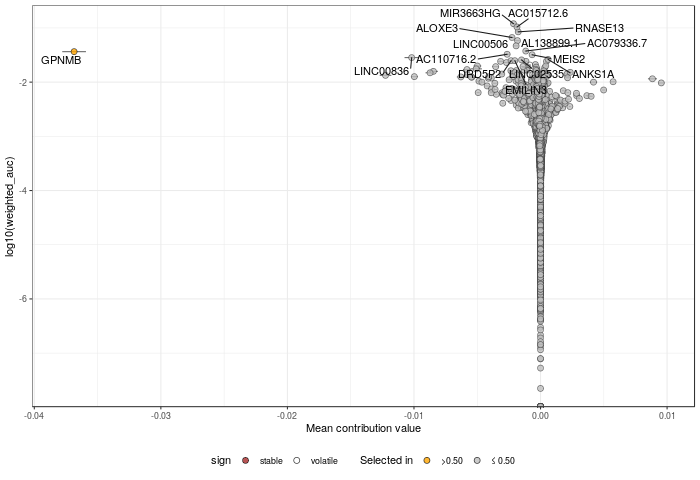

In [108]:
%%R -w 700 -i joint_rna_contribs
coefficients_volcano_plot(
    joint_rna_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean contribution value')

### 2.3. Is the test set "easier"?

Could the better performance of the test set be attributed to the composition difference?
Is there more TMD patients in the TMD+TMR test set compared to train?

In [109]:
df = DataFrame(dict(
    train=joint_cm_and_tmdr.map(clinical.Meningitis_with_tuberculosis_status).value_counts(),
    test=cm_and_tmdr_validation.map(clinical.Meningitis_with_tuberculosis_status).value_counts()
))
df

,train,test
Cryptococcal,14,14
Definite tuberculosis,7,12
Probable tuberculosis,4,6


In [110]:
share = df / df.sum()
share

,train,test
Cryptococcal,0.56,0.4375
Definite tuberculosis,0.28,0.3750
Probable tuberculosis,0.16,0.1875


In [111]:
share.loc['Definite tuberculosis'] / share.loc['Probable tuberculosis']

train    1.75
test     2.00
dtype: float64

Yes, but only slightly.

## 3. Using protein scores extracted by O2PLS

In [112]:
def create_o2pls_pipeline(smallest_group_n, outliers, predict, max_components=2, subset=None, verbose=False, n_jobs=None):

    return TwoBlockPipeline(
        x=preprocess('rna', smallest_group_n, outliers),
        y=preprocess('protein', smallest_group_n, outliers),
        combine=(
            GridSearchCV(
                O2PLS(max_iterations=500, algorithm='nipals'),
                cv=3,  # repeated?
                iid=True,
                scoring={
                    'average_cv_predictions': cv_scoring['average_cv_predictions']
                },
                refit='average_cv_predictions',
                param_grid=[{
                    # remained: the second is non inclusive
                    'joint_components': range(1, max_components),
                    'x_ortho_components': range(0, max_components),
                    'y_ortho_components': range(0, max_components)
                }],
                verbose=verbose,
                n_jobs=n_jobs
            )
        ),
        predict=predict
    )


def predict_protein_scores(pipeline, dataset, calculate='calculate_Y_scores_U_without_osc'):
    prediction = pipeline.call(
        calculate,
        pipeline.y.transform(dataset.y)
    )
    if len(prediction.columns) != 1:  # for more columns, more advanced technique needed
        print('warning: more latent components chosen!', len(prediction.columns))
    return -prediction[0]


o2pls_pipeline = create_o2pls_pipeline(
    smallest_group_n=7,
    outliers=RNA_OUTLIERS,
    verbose=0,
    max_components=2,
    predict=predict_protein_scores
)

[1] "Retaining: 52.62%"
[1] "Retaining: 99.92%"


In [113]:
def two_blocks_for_integration(rna, protein, patients, outliers, dummy_rna=False):
    b = subset(protein, patients, outliers=outliers)

    return [
        # for o2pls we only validate with protein data as we do not have enough paired observations
        b if dummy_rna else subset(rna, patients, outliers=outliers).loc[b.index],
        b
    ]

In [114]:
tms_o2pls_protein_dataset = MultiBlockDataSet(
    [
        *two_blocks_for_integration(
            None, raw_protein_matrix,
            patients=tms_validation, outliers=RNA_OUTLIERS,
            dummy_rna=True
        )
    ],
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 1 outliers


In [115]:
joint_o2pls = cross_validate(
    o2pls_pipeline,
    two_blocks_for_integration(
        raw_rna_matrix, raw_protein_matrix,
        patients=joint_cm_and_tmdr, outliers=RNA_OUTLIERS
    ),
    test_data=two_blocks_for_integration(
        None, raw_protein_matrix,
        patients=cm_and_tmdr_validation, outliers=RNA_OUTLIERS,
        dummy_rna=True
    ),
    n=100,
    verbose=F,
    stratify=T,
    coefficients={'x': 'W', 'y': 'C'},  # alternatives: _x_coefficients, _y_coefficients
    early_normalization=True
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 3 outliers


In [116]:
joint_o2pls.pipeline.combine.best_estimator_.calc_metrics()

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.046915,0.176504,0.046915,0.176504,0.0,0.0,0.078022,0.293532


In [117]:
joint_o2pls.pipeline.combine.best_estimator_.calc_metrics(
    X=joint_o2pls.pipeline.transformed_blocks['x'],
    Y=joint_o2pls.pipeline.transformed_blocks['y']
)

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,0.046915,0.176504,0.11171


In [118]:
tms_o2pls_result = joint_o2pls.validate(tms_o2pls_protein_dataset)
tms_o2pls_result_sub = joint_o2pls.cross_validation.validate(tms_o2pls_protein_dataset)

In [119]:
roc_auc_o2pls = pd.concat([
    joint_o2pls.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    joint_o2pls.sub_sampling_test_results.roc_auc.assign(group='CV test: TMD+TMR vs CM', models='Cross-Validation', set='Test: TMD+TMR vs CM'),
    tms_o2pls_result_sub.roc_auc.assign(group='CV test: TMS vs CM', models='Cross-Validation', set='Test: TMS vs CM'),
    tms_o2pls_result.roc_auc.assign(group='Full test: TMS vs CM', models='Full model', set='Test: TMS vs CM'),
    joint_o2pls.test_result.roc_auc.assign(group='Full test: TMD+TMR vs CM', models='Full model', set='Test: TMD+TMR vs CM')
])

 vs 0.6495833333333334


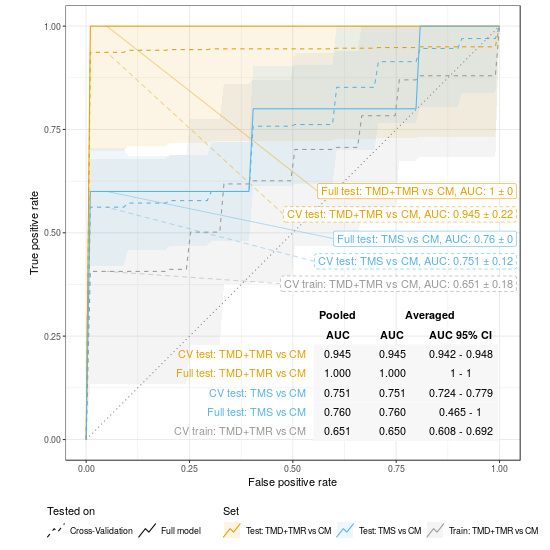

In [120]:
%%R -i roc_auc_o2pls -w 550 -h 550
import::here(plot_roc_auc, add_linetype_to_ggrepel, .from='plots/machine_learning.R')
        
colors = c('Test: TMD+TMR vs CM'='#E69F00', 'Test: TMS vs CM'='#56B4E9', 'Train: TMD+TMR vs CM'='#999999')
p = (
    plot_roc_auc(
        roc_auc_o2pls, annotate_lines=T, table=T,
        color='set', linetype='models',
        random_color='grey50', random_linetype=3,
        table_row_colors=colors, annotation_at=0.05,
        annotation_x=0.05, nudge_x=1,
        nudge_y=-1,
        direction='y',
        ylim=c(0.35, 0.65),
        table_xmin=0.45, table_xmax=0.75
    )
    + scale_color_manual(
        name='Set',
        values=colors
    )
    + scale_fill_manual(
        name='Set',
        values=colors
    )
    + scale_linetype_manual(
        name='Tested on',
        values=c('Cross-Validation'='dashed', 'Full model'='solid')
    )
    + guides(
        linetype=guide_legend(title.position='top'),
        fill=guide_legend(title.position='top'),
        color=guide_legend(title.position='top')
    )
    # + ggtitle()
)

line_types = c(2,1,2,1,2,2)
g = add_linetype_to_ggrepel(ggplotGrob(p), line_types, 'segment')
g = add_linetype_to_ggrepel(g, line_types, 'box')
p = grid.draw(g)

In [121]:
grid_results = add_grid_metadata(format_grid_results(
    joint_o2pls.cross_validation.estimators[0].combine,
    joint_o2pls.cross_validation.estimators[0].transformed_blocks['x']
))

In [122]:
grid_results.head()

,param_joint_components,param_x_ortho_components,param_y_ortho_components,variable,value,...,symbol,joint_mean,mean,std,ortho_gain_percent
0,1.0,0.0,0.0,split0_test_average_cv_predictions,-0.108983,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.074031,0.082760,25.859502
1,1.0,0.0,1.0,split0_test_average_cv_predictions,-0.153090,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.131885,0.079840,-32.079638
2,1.0,1.0,0.0,split0_test_average_cv_predictions,-0.161745,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.093792,0.102389,6.069331
3,1.0,1.0,1.0,split0_test_average_cv_predictions,-0.171337,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.099702,0.104101,0.150805
4,1.0,0.0,0.0,split1_test_average_cv_predictions,0.020471,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.074031,0.082760,25.859502


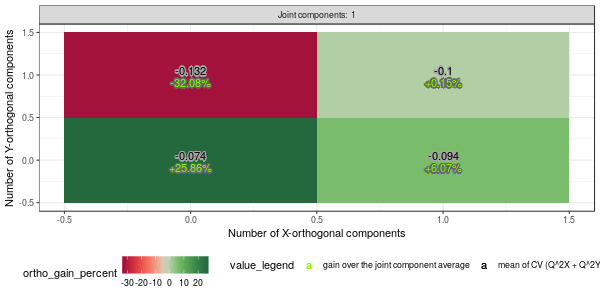

In [123]:
%%R -w 600 -h 300 -i grid_results
grid_orthogonal_components_plot(grid_results)

## Scratchpad and ideas for future research

- Pathways enrichment might be more meaningful with Ridge regularization
- Random forest would be another very simple but potentially useful classifier
- Group LASSO may solve the issue of multi-collinearity, there is an sklearn-API for it: https://pypi.org/project/group-lasso/